In [1]:
# Pandas library for the pandas dataframes and other plotting tools
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
matplotlib.rcParams.update({'font.size': 18})
%matplotlib inline

# Import Scikit-Learn library for models
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix # plotting confusion matrix 
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Import cleaning and splitting functions
from clean_split_data import clean_data
from clean_split_data import split_data

# For confusion matrix count
from collections import Counter

### Data

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data = clean_data(data)
X_train, X_test, y_train, y_test = split_data(data)

### Classifier

In [4]:
k_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
list_mse = []
for neighbors in k_neighbors_list:
    clf = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    list_mse.append(mean_squared_error(y_test, y_pred))

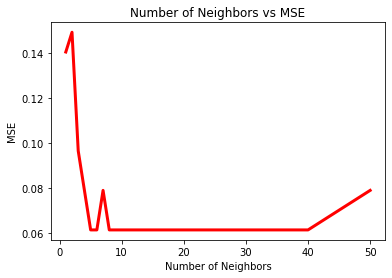

In [5]:
plt.plot(k_neighbors_list, list_mse, c='r', linewidth=3)
plt.xlabel('Number of Neighbors')
plt.ylabel('MSE')
plt.title('Number of Neighbors vs MSE')
plt.show()

In [6]:
list_mse.index(min(list_mse))

4

In [7]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

Therefore 5 k_neighbors is the best.

### kNN Prediction (User Input)

In [8]:
def predict(test_data):
    '''
    Takes test data and uses classifier to predict boolean output.
    '''
    y_pred = clf.predict(test_data)
    
    return y_pred

### Sample Train, Test, Splits Results

In [9]:
def sample_results():
    '''
    Returns the results and confusion matrix of the sample dataset from Breast Cancer Wisconsin Dataset.
    '''
    y_pred = clf.predict(X_test)
    ones_incorrect = 0
    zeros_incorrect = 0    
    y_test_list = list(y_test)
    y_pred_list = list(y_pred)
    for test, pred in zip(y_test_list, y_pred_list):
        if test == 0 and test != pred:
            zeros_incorrect += 1
        elif test == 1 and test != pred:
            ones_incorrect += 1
        else:
            pass
    zeros_true, ones_true = y_test.value_counts()
    zeros_correct = zeros_true - zeros_incorrect
    ones_correct = ones_true - ones_incorrect
    confusion_array = [[zeros_correct, zeros_incorrect],
                        [ones_incorrect, ones_correct]]
    df_confusion = pd.DataFrame(confusion_array, index=["0", "1"], columns=["0", "1"])
    print("Mean accuracy of prediction", clf.score(X_test, y_test))
    print("The following table is the classification report for model predictions: ")
    print(classification_report(y_test, y_pred))
    print("The confusion matrix for the sample dataset using kNN Neighbors is displayed below: ")
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.set(font_scale=1.5)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.set_ylabel("True label", fontsize=15)
    sns.heatmap(df_confusion, annot=True, cmap='viridis', ax=ax)
#     plt.figure(figsize = (10,7))
#     plt.show()

Mean accuracy of prediction 0.9385964912280702
The following table is the classification report for model predictions: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.97      0.86      0.91        43

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

The confusion matrix for the sample dataset using kNN Neighbors is displayed below: 


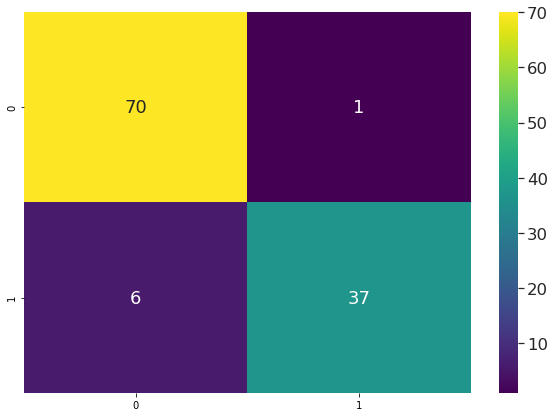

In [10]:
sample_results()

### Backwards Stepwise Feature Selection

In [11]:
#Defining Dataset Input Features and Outputs
X = data[['radius_mean', 'texture_mean', 'perimeter_mean',
   'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
   'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = data.diagnosis

In [12]:
input_features_count = [1, 2, 3, 4, 5, 6, 7, 8, 9]

list_test_mse = []
list_test_R2 = []
list_test_accuracy = []

list_training_mse = []
list_training_R2 = []
list_training_accuracy = []

selected_features = []

K_neighbors = 5
classifier = KNeighborsClassifier(K_neighbors)

for count in input_features_count:
    sfs_backward = SequentialFeatureSelector(classifier,
                                         n_features_to_select=(count),
                                         direction='backward').fit(X, y)

    f_names = np.array(X.columns)
    selected = sfs_backward.get_support(indices=True)
    X_selected = data[f_names[selected]]
    selected_features.append(f_names[selected])
    X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    clf_knn = KNeighborsClassifier(K_neighbors)
    clf_knn = clf_knn.fit(X_train_selected, y_train_selected)
    
    y_test_pred = clf_knn.predict(X_test_selected)
    list_test_mse.append(mean_squared_error(y_test_selected, y_test_pred))
    list_test_R2.append(r2_score(y_test_selected, y_test_pred))
    list_test_accuracy.append(accuracy_score(y_test_selected, y_test_pred))
    
    y_train_pred = clf_knn.predict(X_train_selected)
    list_training_mse.append(mean_squared_error(y_train_selected, y_train_pred))
    list_training_R2.append(r2_score(y_train_selected, y_train_pred))
    list_training_accuracy.append(accuracy_score(y_train_selected, y_train_pred))

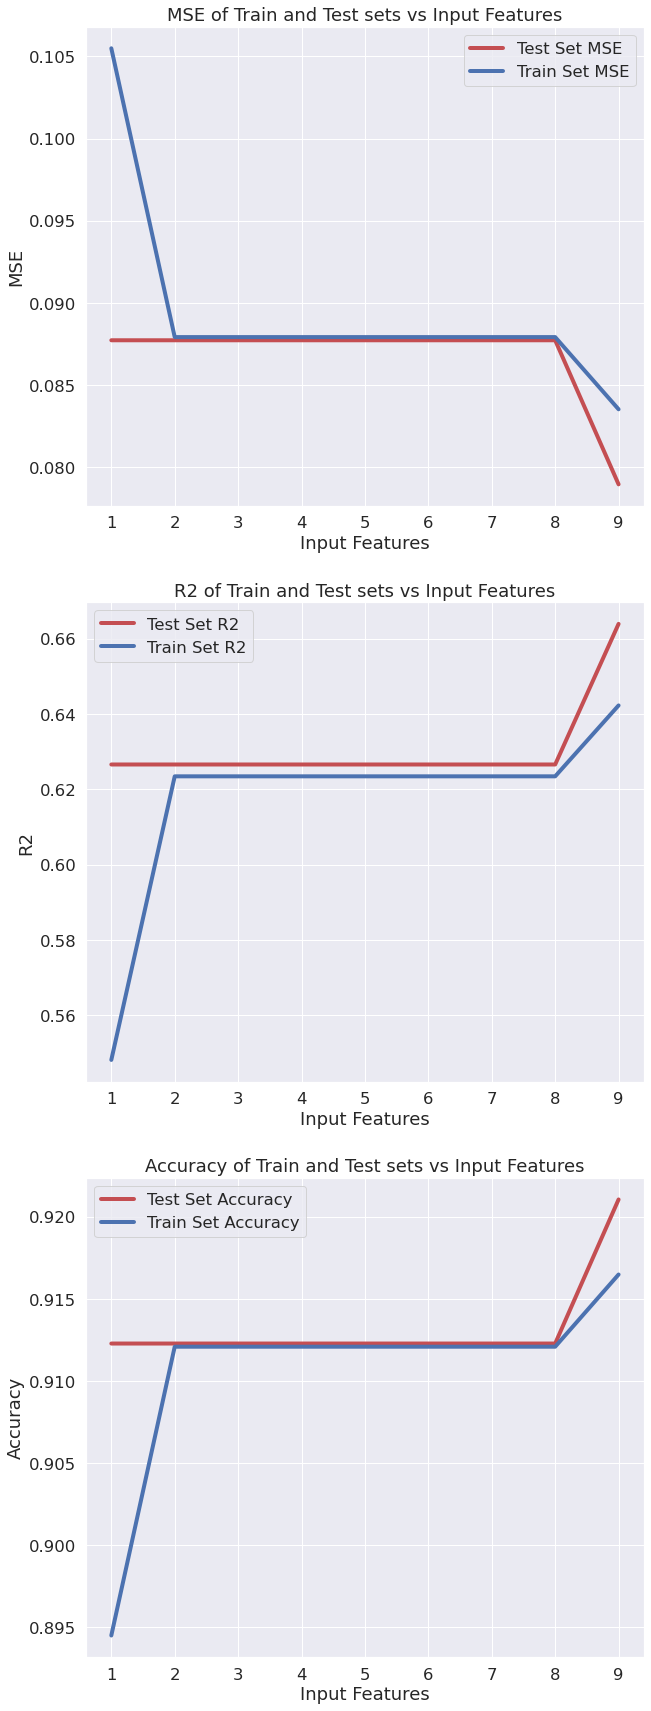

In [13]:
nrows = 3
fig = plt.figure(figsize=(10, nrows * 10))
ax = fig.subplots(nrows=nrows, ncols=1)

ax[0].plot(input_features_count, list_test_mse, label='Test Set MSE', c='r', linewidth=4)
ax[0].plot(input_features_count, list_training_mse, label='Train Set MSE', c='b', linewidth=4)
ax[0].set_xlabel('Input Features')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE of Train and Test sets vs Input Features')
ax[0].legend()

ax[1].plot(input_features_count, list_test_R2, label='Test Set R2', c='r', linewidth=4)
ax[1].plot(input_features_count, list_training_R2, label='Train Set R2', c='b', linewidth=4)
ax[1].set_xlabel('Input Features')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 of Train and Test sets vs Input Features')
ax[1].legend()

ax[2].plot(input_features_count, list_test_accuracy, label='Test Set Accuracy', c='r', linewidth=4)
ax[2].plot(input_features_count, list_training_accuracy, label='Train Set Accuracy', c='b', linewidth=4)
ax[2].set_xlabel('Input Features')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy of Train and Test sets vs Input Features')
ax[2].legend()

In [14]:
selected_features[3]

array(['texture_mean', 'perimeter_mean', 'symmetry_mean',
       'fractal_dimension_mean'], dtype=object)